In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
df_1 = pd.read_csv(
    "Fill the path of bottle.csv"
)
df_2 = pd.read_csv(
    "Fill the path of cast.csv"
)
data = pd.merge(df_1, df_2, on='Cst_Cnt', how='left')



/tmp/ipykernel_55/1962470106.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv(
/tmp/ipykernel_55/1962470106.py:4: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv(


In [65]:
target_col = 'T_degC' 

X = data.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = data[target_col]


In [72]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

y = y.fillna(y.mean())


In [73]:

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [74]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

In [76]:
y_pred = lr.predict(X_test_scaled)

In [83]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Baseline Linear Regression Performance ---")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

--- Baseline Linear Regression Performance ---
MSE:  0.0000
RMSE: 0.0006
R²:   1.0000


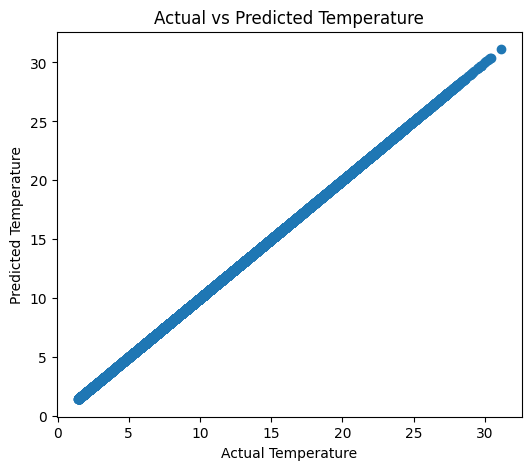

In [78]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()

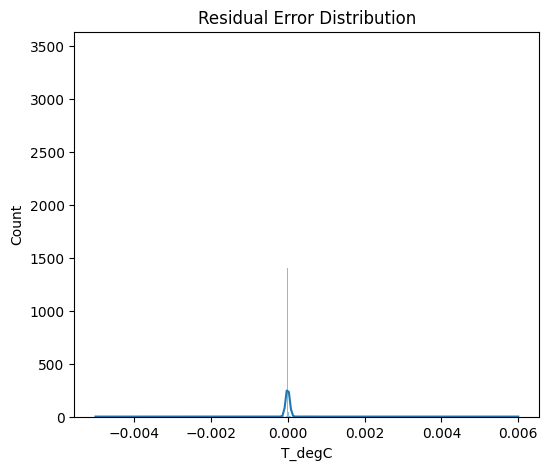

In [80]:
residuals = y_test - y_pred

plt.figure(figsize=(6,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Error Distribution")
plt.show()

In [79]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)
print("Ridge R2 Score:", r2_score(y_test, ridge_pred))


Ridge R2 Score: 0.9999999817891593


In [81]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)
print("Lasso R2 Score:", r2_score(y_test, lasso_pred))


Lasso R2 Score: 0.9999943601254198


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [ ]:
lic = pd.read_csv("Fill the path of LICI - minute ata.csv")
lic.head()
lic.shape

(34846, 6)

In [16]:
lic['Price_Movement'] = np.where(lic['close'] > lic['open'], 1, 0)
lic.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Price_Movement'], dtype='object')

In [17]:
X2 = lic[['open', 'high', 'low', 'volume']]
y2 = lic['Price_Movement']


In [18]:
# More efficient: compute median once per column
X2 = X2.fillna(X2.median())

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)


In [20]:
scaler2 = StandardScaler()

X_train2_scaled = scaler2.fit_transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)


In [21]:
# Add max_iter and n_jobs for better performance
log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
log_model.fit(X_train2_scaled, y_train2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [22]:
y_pred2 = log_model.predict(X_test2_scaled)


In [23]:
# More efficient: compute metrics in one pass using classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2, target_names=['Down', 'Up']))

              precision    recall  f1-score   support

        Down       0.57      1.00      0.73      3927
          Up       1.00      0.04      0.07      3043

    accuracy                           0.58      6970
   macro avg       0.79      0.52      0.40      6970
weighted avg       0.76      0.58      0.44      6970



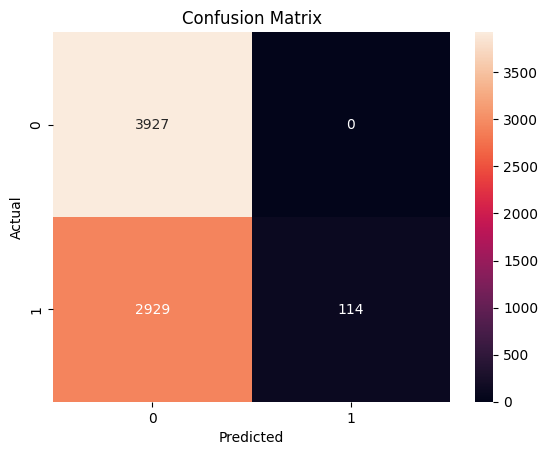

In [24]:
cm = confusion_matrix(y_test2, y_pred2)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


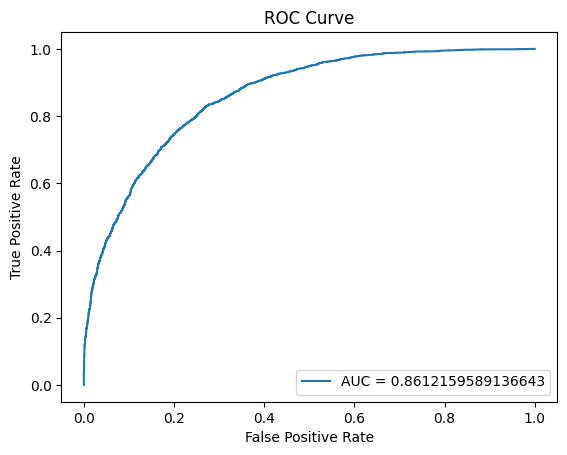

In [25]:
y_prob = log_model.predict_proba(X_test2_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_test2, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = " + str(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [26]:
importance_log = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': log_model.coef_[0]
})

importance_log


,Feature,Importance
0,open,-21.658316
1,high,13.323135
2,low,8.364726
3,volume,-0.030914


In [27]:
model_l2 = LogisticRegression(C=0.5, penalty='l2', max_iter=1000, n_jobs=-1)
model_l2.fit(X_train2_scaled, y_train2)

pred_l2 = model_l2.predict(X_test2_scaled)
print("Optimized L2 Accuracy:", accuracy_score(y_test2, pred_l2))

Optimized L2 Accuracy: 0.5672883787661406


In [ ]:
model_l1 = LogisticRegression(C=0.5, penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train2_scaled, y_train2)

pred_l1 = model_l1.predict(X_test2_scaled)
print("Optimized L1 Accuracy:", accuracy_score(y_test2, pred_l1))